# Implementation of matrix factorization using SVD from RecTools for getting recommendations.

## Imports

In [1]:
import sys
sys.path.append("../")

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import typing as tp
import numpy as np

from scipy.sparse import coo_matrix
from rectools.models import PureSVDModel
from rectools.dataset import Dataset
from rectools.columns import Columns
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from src.utils import rec_imaging

## Data preparation

In [10]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [11]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [12]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "weight",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [13]:
interactions = interactions[interactions["item_name"].notna()]
interactions = interactions[interactions["weight"] > 0]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [14]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "weight": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)
interactions["datetime"] = datetime.datetime.today()

## Model

In [15]:
interactions = interactions.rename(columns={"score": "weight"})

In [16]:
dataset = Dataset.construct(interactions_df=interactions[["user_id", "item_id", "weight", "datetime"]])

In [34]:
model = PureSVDModel()

In [35]:
model.fit(dataset)

In [36]:
interactions.user_id.unique()

array([    0,     1,     2, ..., 68088, 68089, 68090])

In [37]:
recs = model.recommend(
    users=interactions.user_id.unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False    
)

In [49]:
recs[recs.user_id == 1].score.values

array([0.02719009, 0.01593561, 0.01436295, 0.01065957, 0.01044482,
       0.0100853 , 0.00896572, 0.00865095, 0.00806397, 0.00801011],
      dtype=float32)

In [50]:
class RecSysModel:
    def __init__(
        self,
        interactions_df: pd.DataFrame,
    ) -> None:
        self.content_dict = {}
        self.interactions_df = interactions_df[Columns.Interactions]

        # Fill dict with content
        for i, j, k in interactions_df[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

    def fit(
        self,
        k: int = 30
    ) -> None:
        self.dataset = Dataset.construct(
            interactions_df=self.interactions_df
        )
        
        self.model = PureSVDModel(factors=k)

        self.model.fit(self.dataset)

    def predict(
        self,
        filter_viewed: bool = False,
    ) -> None:
        users = self.interactions_df.user_id.unique()
        self.recommendations = self.model.recommend(
            users=users,
            dataset=self.dataset,
            k=10,
            filter_viewed=filter_viewed
        )

    def get_rec(
        self,
        i: int
    ) -> None:
        viewed_items = self.interactions_df[self.interactions_df.user_id == i].item_id.values
        recommendations = self.recommendations[self.recommendations.user_id == i].item_id.values
        metrics = self.recommendations[self.recommendations.user_id == i].score.values
        print("For items:")
        rec_imaging(viewed_items, self.content_dict)
        print("Such recommendations:")
        rec_imaging(
            recommendations,
            self.content_dict,
            metrics
        )


In [51]:
model = RecSysModel(interactions)

In [52]:
model.fit()

In [53]:
model.predict()

In [ ]:
def MSE_Loss_parallel(
        self,
        U: np.ndarray,
        V: np.ndarray,
        i: int
    ) -> float:
        """
        Calculates Mean Squared Error loss.
        
        Function calculates MSE Loss only for rated items.
        """

        for i in tqdm(range(10000)):
            pass

        return 1

        part = model.rates_cnt // MAX_CPU
        i_split = i
        if i_split != MAX_CPU - 1:
            rates_slice = self.interactions_df.iloc[part * i_split:part * (i_split + 1)]
        else:
            rates_slice = self.interactions_df.iloc[part * i_split:]

        mse = 0
        self.rates = self.rates.toarray()
        for i in tqdm(range(rates_slice.shape[0])):
            user_id = self.interactions_df.iloc[i]["user_id"]
            item_id = self.interactions_df.iloc[i]["item_id"]
            mse += (self.rates[user_id][item_id] - np.dot(U[user_id, :], V[:, item_id])) ** 2 / rates_slice.shape[0]

        return mse

## View recommendations

For items:


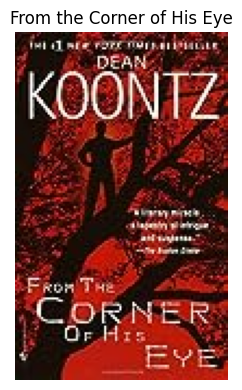

Such recommendations:


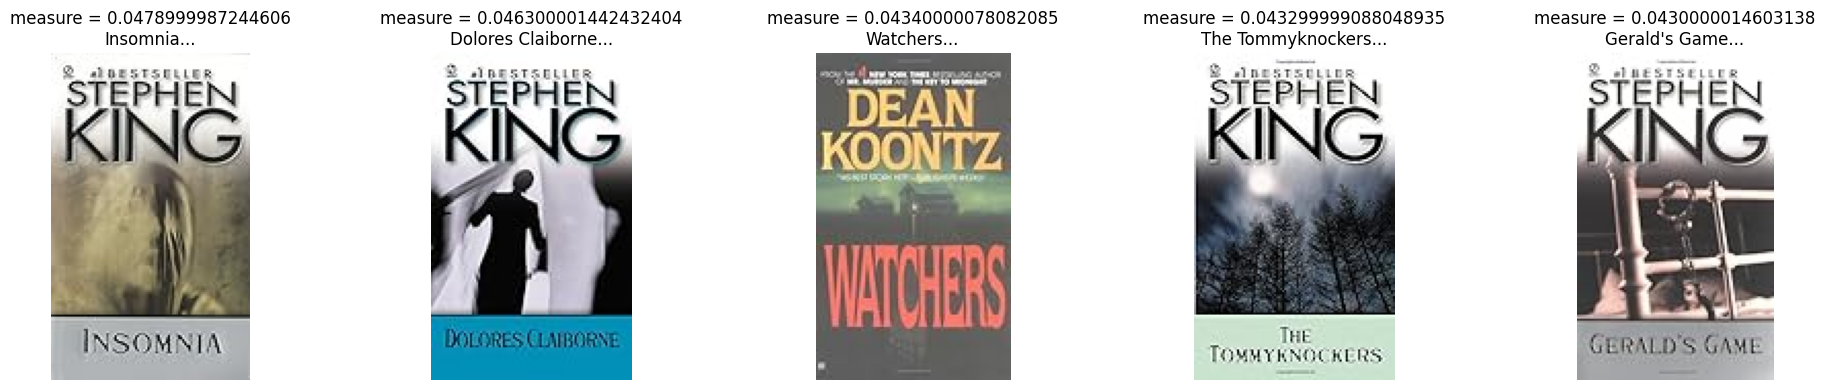

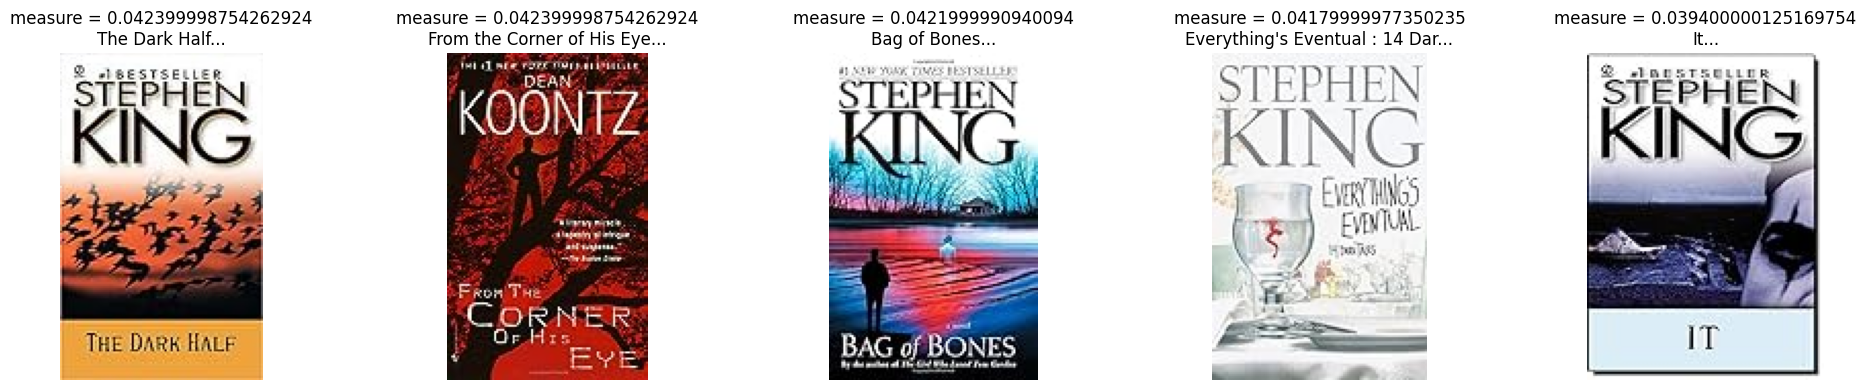

In [56]:
model.get_rec(11)